###Import

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

In [2]:
import os
from datasets import Dataset, DatasetDict, Image
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

###Utils

In [3]:
# Creating mapping between id and label
id2label = {0: 'sky',
            1:'building',
            2:'pole',
            3: 'road',
            4:'pavement',
            5: 'tree',
            6: 'signsymbol',
            7: 'fence',
            8: 'car',
            9: 'pedestrian',
            10: 'bicyclist',
            11: 'unlabelled'}
with open('id2label.json', 'w') as fp:
    json.dump(id2label, fp)

def plot_segmentation_map(segmentation_map):

    n_classes = len(id2label)
    cmap = plt.get_cmap('tab20', n_classes)
    norm = mcolors.BoundaryNorm(np.arange(n_classes + 1) - 0.5, n_classes)

    plt.figure(figsize=(10, 10))
    plt.imshow(segmentation_map, cmap=cmap, norm=norm)

    cbar = plt.colorbar(ticks=np.arange(n_classes))
    cbar.ax.set_yticklabels([id2label[i] for i in range(n_classes)])

    plt.title("Segmentation Map")
    plt.show()


###Download dataset
CamVid Image Segmentation dataset. 360x480 RGB street scenes images.

In [4]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

Loading data...
Done!


In [5]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

###Creating a DatasetDict
The DatasetDict dataset will be used to create a PyTorch dataset to be used in the fine-tuning process.

In [6]:
def create_dataset(image_paths, label_paths):
  dataset = Dataset.from_dict({"image": sorted(image_paths),
                                "label": sorted(label_paths)})
  dataset = dataset.cast_column("image", Image())
  dataset = dataset.cast_column("label", Image())

  return dataset


In [7]:
train_image_paths = os.listdir(x_train_dir)
train_image_paths = [os.path.join(x_train_dir, file_name) for file_name in train_image_paths]
train_label_paths = os.listdir(y_train_dir)
train_label_paths = [os.path.join(y_train_dir, file_name) for file_name in train_label_paths]

val_image_paths = os.listdir(x_valid_dir)
val_image_paths = [os.path.join(x_valid_dir, file_name) for file_name in val_image_paths]
val_label_paths = os.listdir(y_valid_dir)
val_label_paths = [os.path.join(y_valid_dir, file_name) for file_name in val_label_paths]

test_image_paths = os.listdir(x_test_dir)
test_image_paths = [os.path.join(x_test_dir, file_name) for file_name in test_image_paths]
test_label_paths = os.listdir(y_test_dir)
test_label_paths = [os.path.join(y_test_dir, file_name) for file_name in test_label_paths]

train_ds = create_dataset(train_image_paths, train_label_paths)
val_ds = create_dataset(val_image_paths, val_label_paths)
test_ds = create_dataset(test_image_paths, test_label_paths)

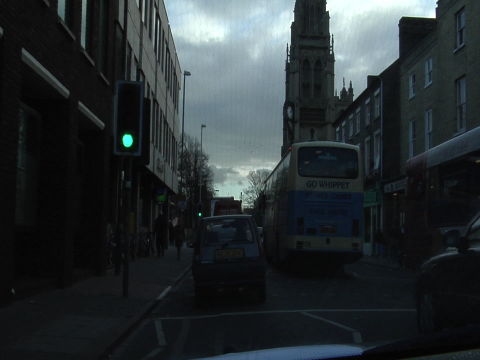

In [8]:
example = train_ds[1]
example['image']

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 4,  4,  4, ..., 11, 11, 11],
       [ 4,  4,  4, ..., 11, 11, 11],
       [ 4,  4,  4, ..., 11, 11, 11]], dtype=uint8)
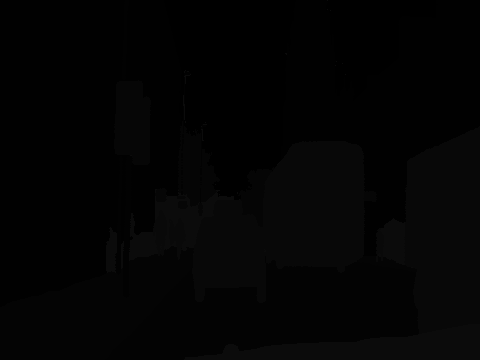

In [9]:
# An exemple of segmentation map
segmentation_map = np.array(example['label'])
segmentation_map

In [10]:
np.unique(segmentation_map)

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 11], dtype=uint8)

In [11]:
# List of labels present in the image
labels = [id2label[label] for label in np.unique(segmentation_map)]
print(labels)

['sky', 'building', 'pole', 'road', 'pavement', 'tree', 'signsymbol', 'car', 'pedestrian', 'unlabelled']


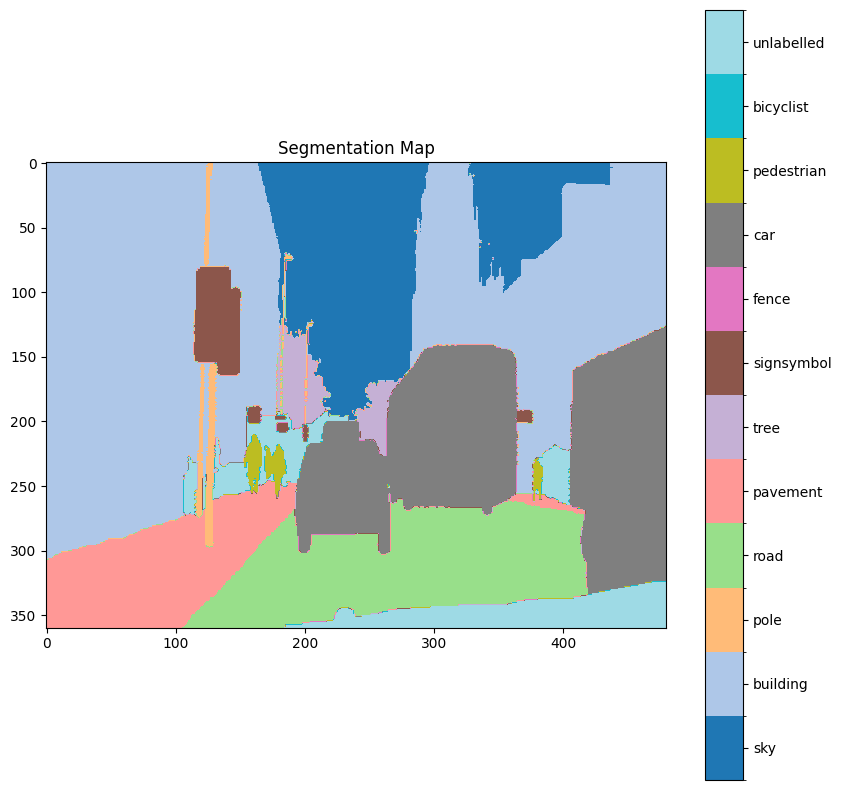

In [12]:
# Visualizing the segmentation map
plot_segmentation_map(segmentation_map)

###PyTorch Dataset

In [13]:
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['image'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])

        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

####Data Augmentation  

In [14]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.2),
    A.Perspective(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
    ###May add more transformations
])

test_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),

])

train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
val_dataset = ImageSegmentationDataset(val_ds, transform=test_transform)
test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)

In [15]:
image, segmentation_map, _, _ = train_dataset[0]
print(image.shape)
print(segmentation_map.shape)

(3, 512, 512)
(512, 512)


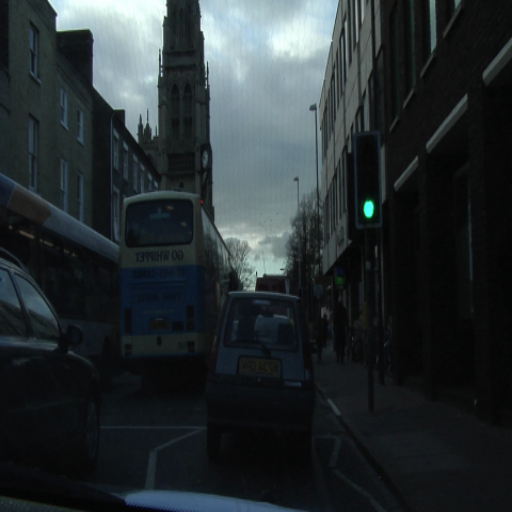

In [16]:
from PIL import Image

unnormalized_image = (image * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [17]:
segmentation_map.shape

(512, 512)

In [18]:
# List of labels present in the image
labels = [id2label[label] for label in np.unique(segmentation_map)]
print(labels)


['sky', 'building', 'pole', 'road', 'pavement', 'tree', 'signsymbol', 'car', 'pedestrian', 'unlabelled']


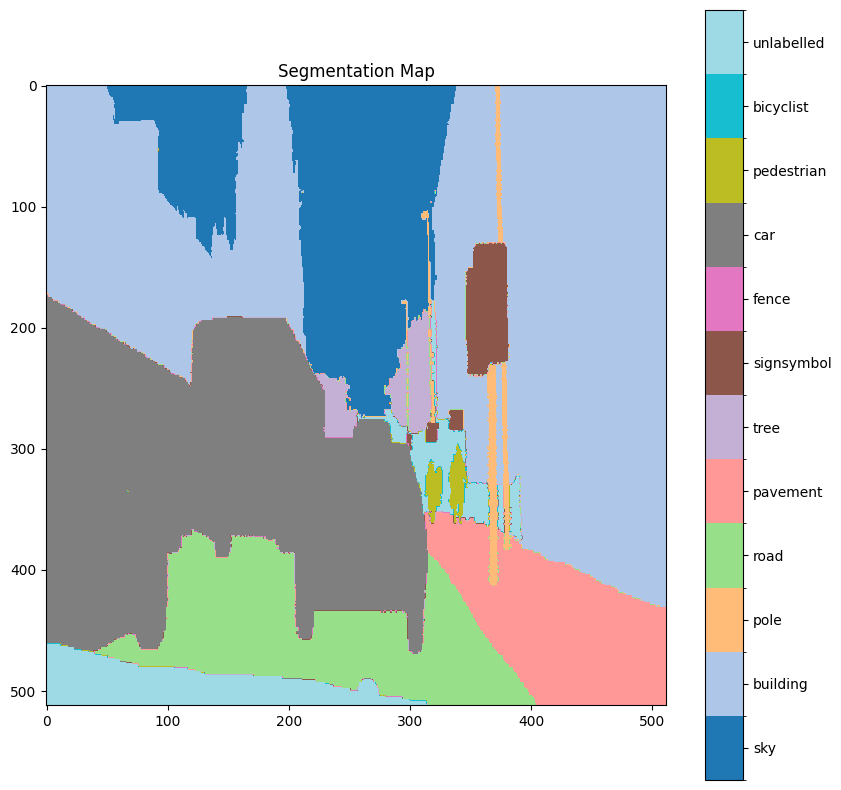

In [19]:
plot_segmentation_map(segmentation_map)

###Data Loader

In [20]:
from transformers import MaskFormerImageProcessor

preprocessor = MaskFormerImageProcessor(
    #Specify class labell to assign to background
    ignore_index=11,
    do_reduce_labels=False,
    do_resize=False,
    do_rescale=False,
    do_normalize=False)


In [21]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)


####Checking correct input

In [22]:
import torch

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
mask_labels torch.Size([8, 512, 512])
class_labels torch.Size([8])
original_images (360, 480, 3)
original_segmentation_maps (360, 480)


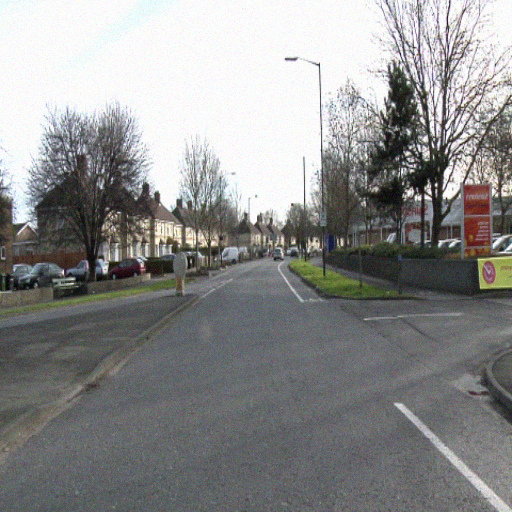

In [23]:
pixel_values = batch['pixel_values'][0].numpy()
unnormalized_image = (pixel_values * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [24]:
# verify class labels
labels = [id2label[label] for label in batch["class_labels"][0].tolist()]
print(labels)

['sky', 'building', 'pole', 'road', 'pavement', 'tree', 'signsymbol', 'car']


In [25]:
def visualize_mask(labels, label_name):
  print("Label:", label_name)
  idx = labels.index(label_name)

  visual_mask = (batch["mask_labels"][0][idx].bool().numpy() * 255).astype(np.uint8)
  return Image.fromarray(visual_mask)

Label: car


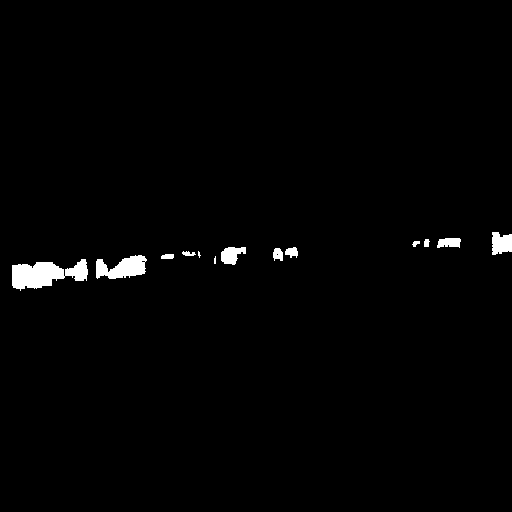

In [26]:
visualize_mask(labels, 'car')

###MaskFormer

In [27]:
from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([13, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([13]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
# Function to count the total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to calculate the size of the model in megabytes
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024 ** 2
    return size_all_mb

# Get the total number of parameters
num_params = count_parameters(model)
print(f'Total number of parameters: {num_params}')

# Get the size of the model
model_size = get_model_size(model)
print(f'Model size: {model_size:.2f} MB')


Total number of parameters: 101795973
Model size: 392.12 MB


####Load
Loading trained transformers from google drive.

In [29]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [30]:
# Downloading model from HugginFace

from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)


Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([13, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([13]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# Initialize optimizer
import torch
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [32]:
cd '/content/drive/MyDrive/Colab Notebooks/Vision project/Segmentation on CamVid/Weights/mask_former'

/content/drive/MyDrive/Colab Notebooks/Vision project/Segmentation on CamVid/Weights/mask_former


In [33]:
# Load the model
checkpoint = torch.load('trained_mask_former.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# Put model in evaluation mode
model.eval()

MaskFormerForInstanceSegmentation(
  (model): MaskFormerModel(
    (pixel_level_module): MaskFormerPixelLevelModule(
      (encoder): MaskFormerSwinBackbone(
        (model): MaskFormerSwinModel(
          (embeddings): MaskFormerSwinEmbeddings(
            (patch_embeddings): MaskFormerSwinPatchEmbeddings(
              (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (encoder): MaskFormerSwinEncoder(
            (layers): ModuleList(
              (0): MaskFormerSwinStage(
                (blocks): ModuleList(
                  (0-1): 2 x MaskFormerSwinLayer(
                    (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                    (attention): MaskFormerSwinAttention(
                      (self): MaskFormerSwinSelfAttention(
                        (query): Linear(in_

##Real images example


In [34]:
cd '/content/drive/MyDrive/Colab Notebooks/Vision project/Segmentation on CamVid/Real test images'

/content/drive/MyDrive/Colab Notebooks/Vision project/Segmentation on CamVid/Real test images


In [43]:
# prompt: read all the images in the directory i just mounted

import glob
image_paths = glob.glob('*.jpg')  # Assuming images are in JPG format
images = []
for image_path in image_paths:
  image = Image.open(image_path)
  images.append(image)


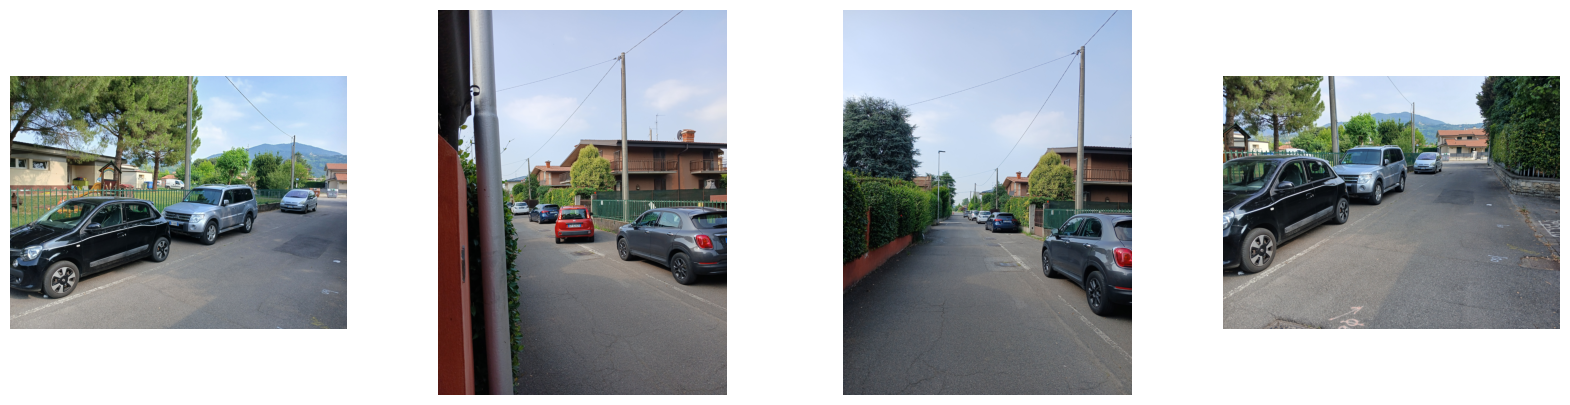

In [44]:
# prompt: rotate the second and third image right by ninety degrees, then plot all the images

import matplotlib.pyplot as plt
images[1] = images[1].rotate(270, expand=True)
images[2] = images[2].rotate(270, expand=True)

# Plot all the images
fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
for i, image in enumerate(images):
    axes[i].imshow(image)
    axes[i].axis('off')
plt.show()


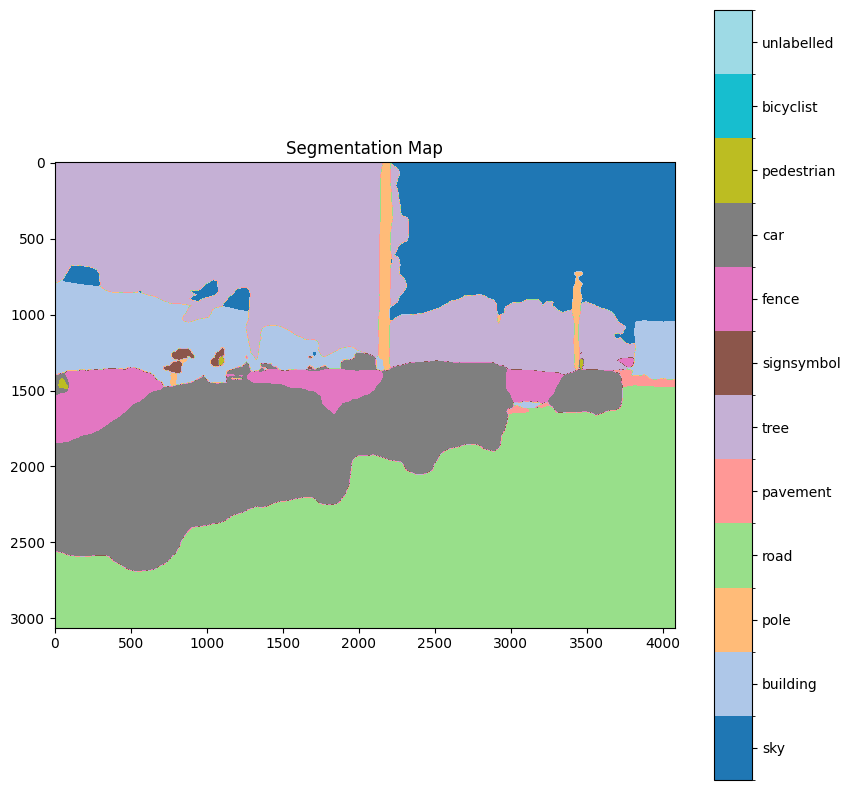

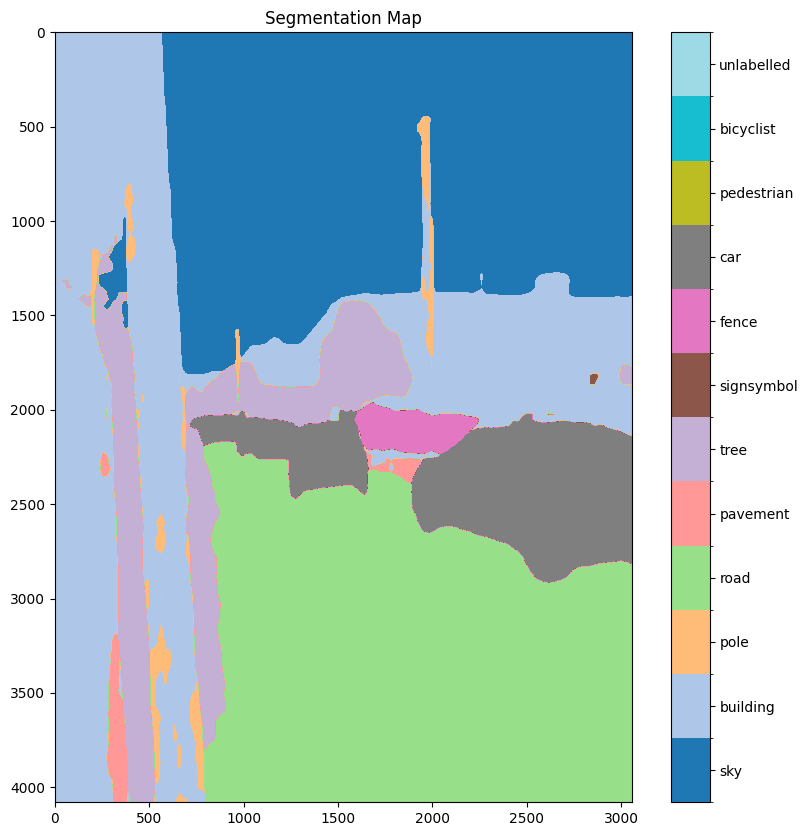

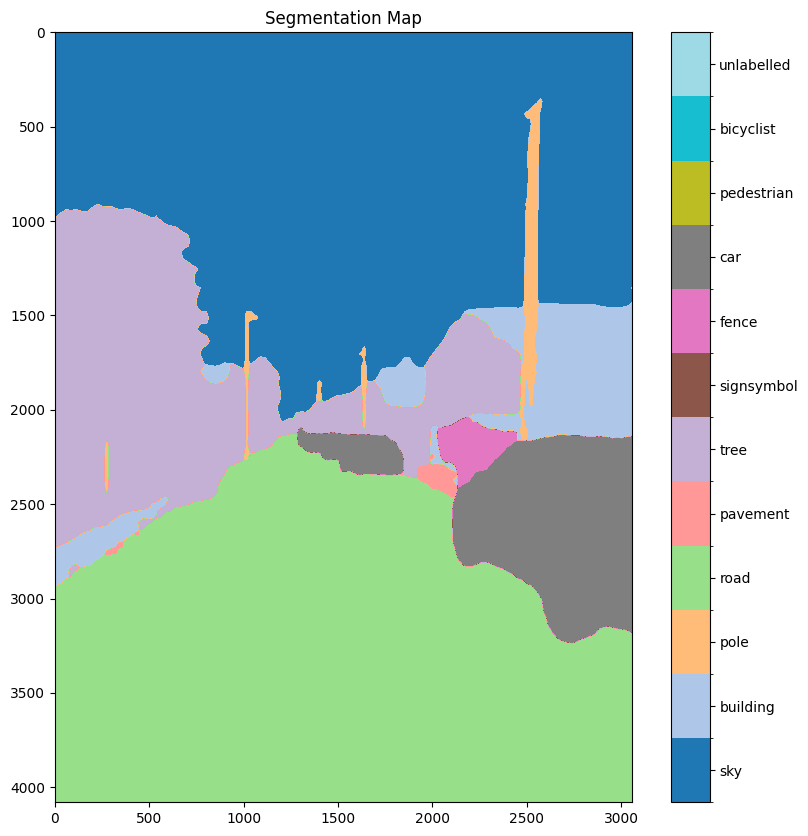

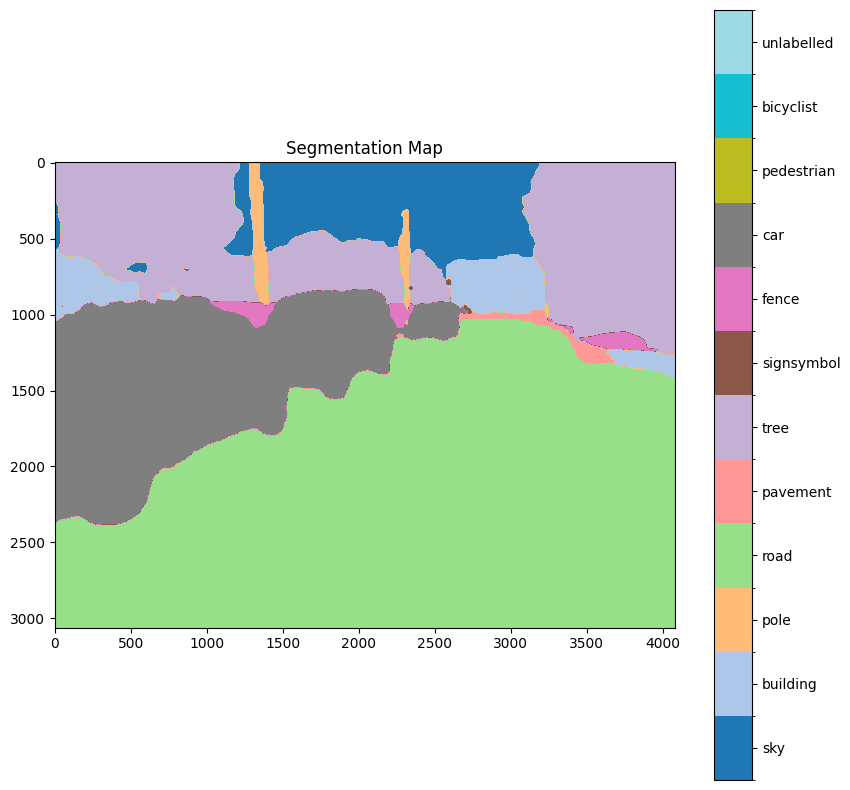

In [45]:
# prompt: use the model i fine-tuned before to produce segmentation map for the images you read before

import numpy as np
# Assuming 'model' and 'preprocessor' are already defined from the previous code

transformed_images = []
for image in images:
  transformed_image = test_transform(image=np.array(image))['image']
  transformed_images.append(transformed_image)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Convert to tensor and move to device
transformed_images_tensor = torch.stack([torch.tensor(img.transpose(2, 0, 1)) for img in transformed_images]).to(device)

# Inference
with torch.no_grad():
  outputs = model(pixel_values=transformed_images_tensor)

# Post-process
target_sizes = [(image.size[1], image.size[0]) for image in images]  # Note: PIL Image uses (width, height)
predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

# Display results
for i, segmentation_map in enumerate(predicted_segmentation_maps):
  segmentation_map = segmentation_map.cpu().numpy()
  plot_segmentation_map(segmentation_map)


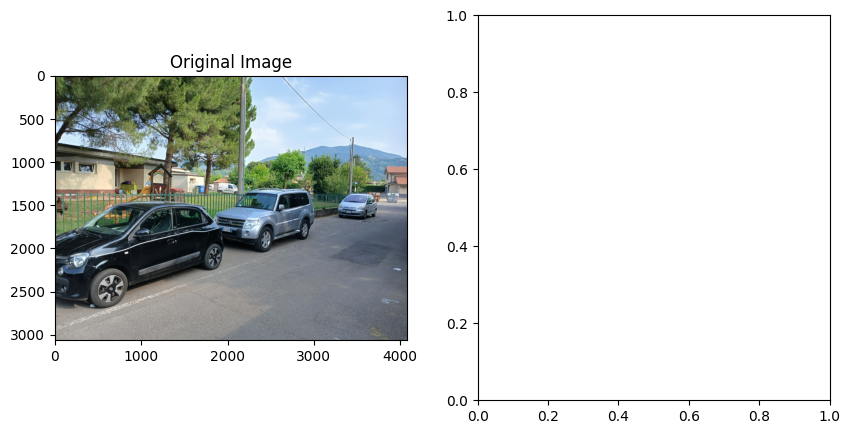

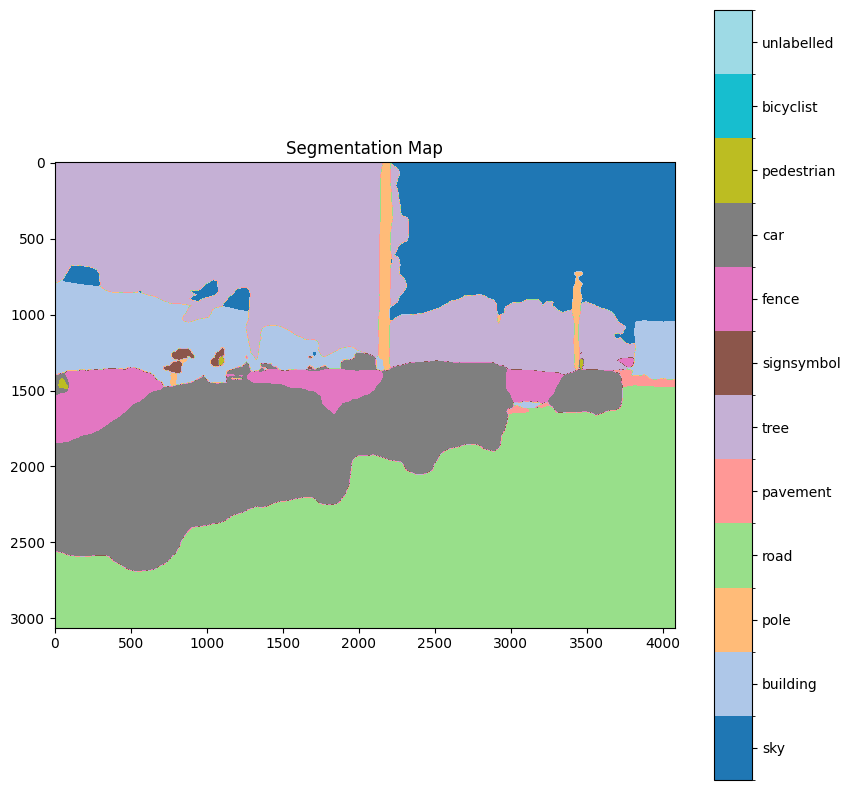

<Figure size 640x480 with 0 Axes>

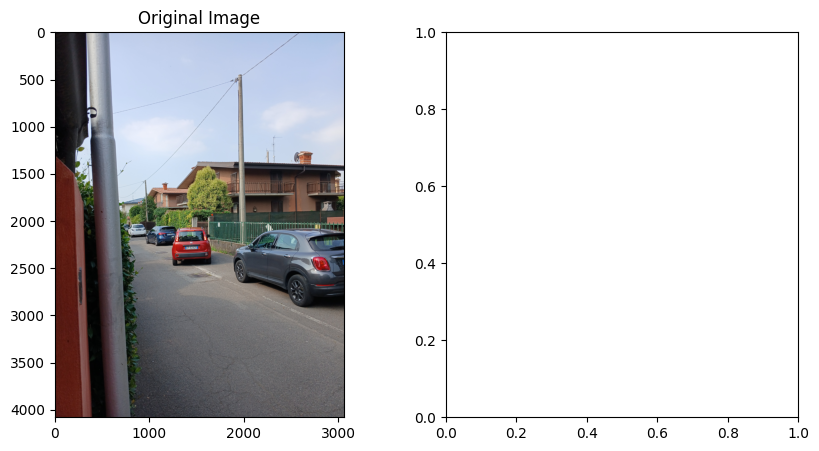

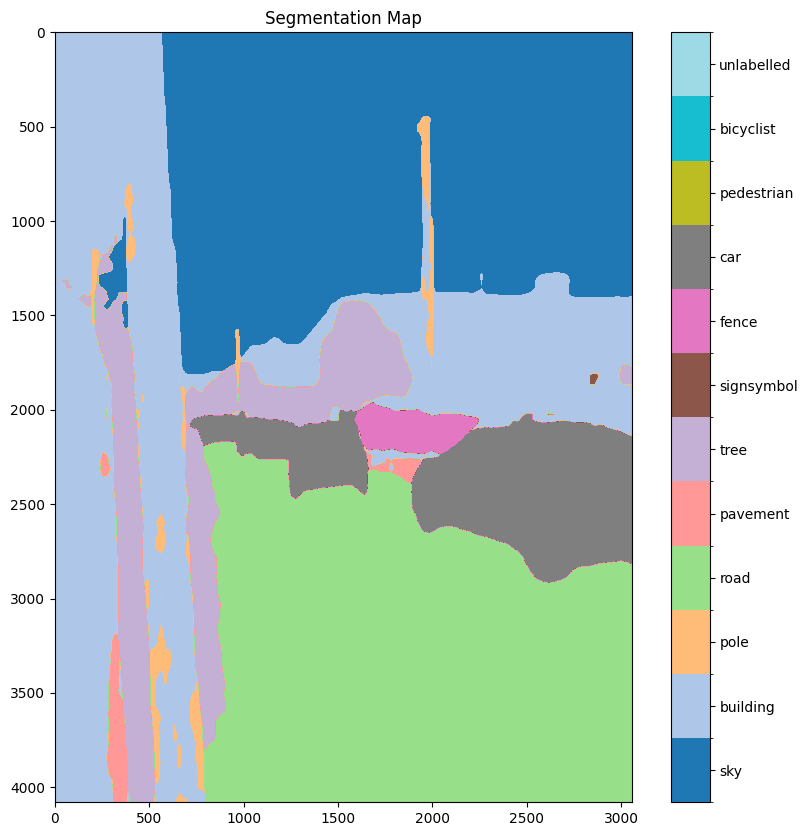

<Figure size 640x480 with 0 Axes>

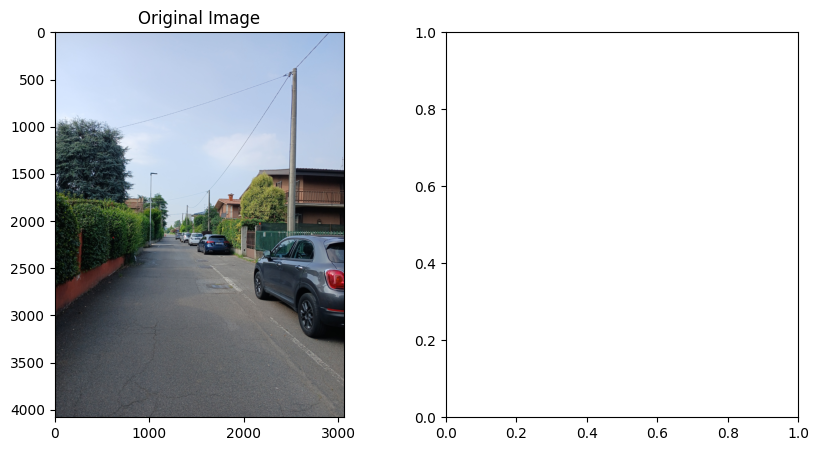

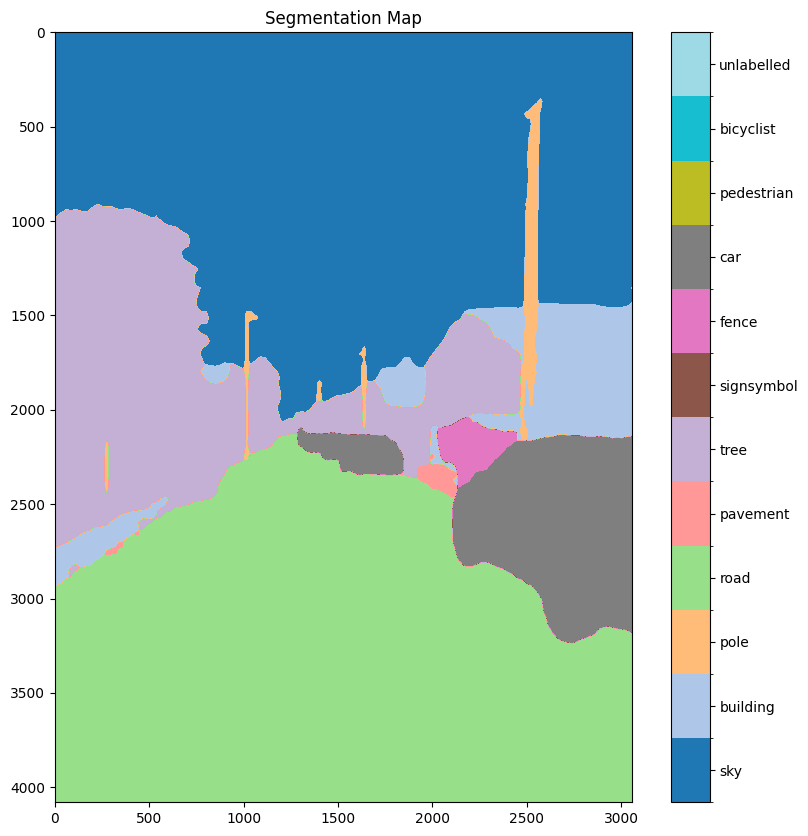

<Figure size 640x480 with 0 Axes>

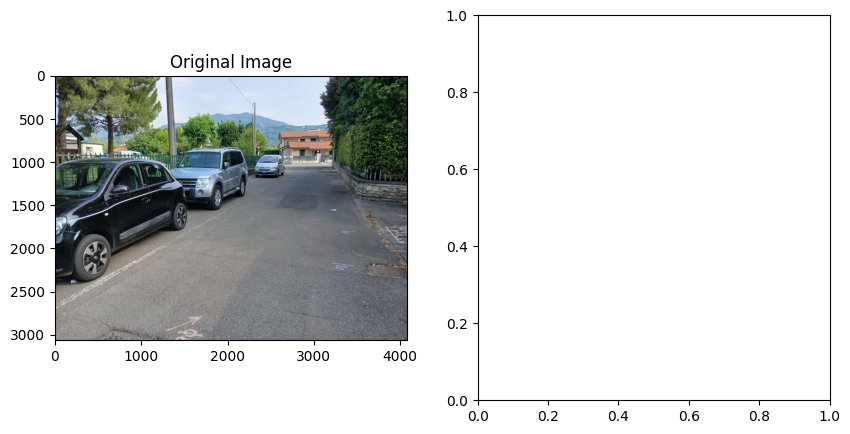

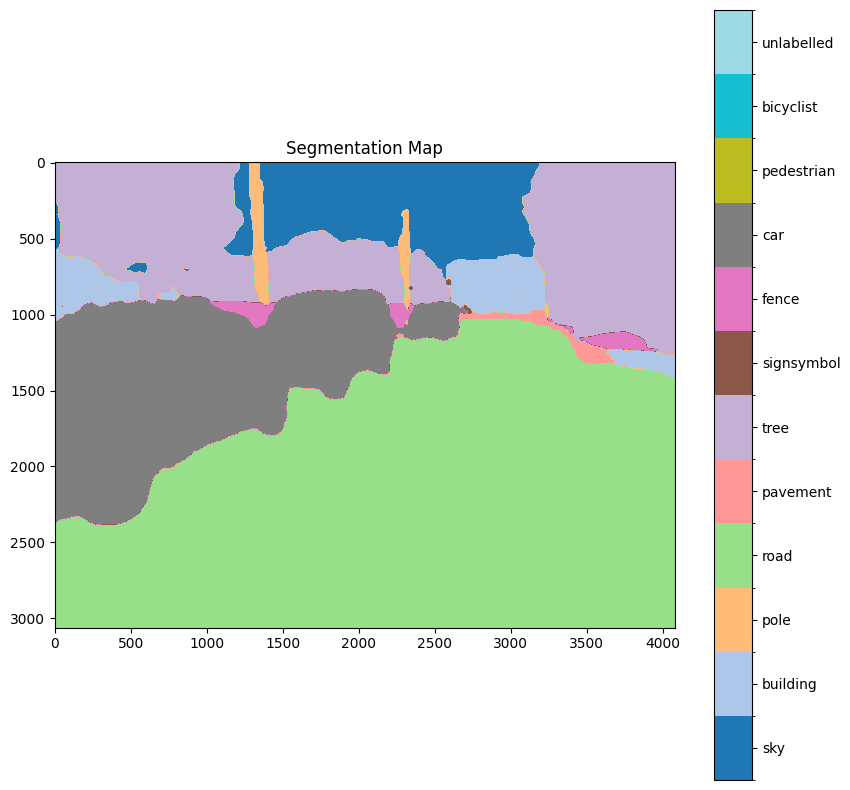

<Figure size 640x480 with 0 Axes>

In [46]:
# prompt: show the predictions together with the original image

import matplotlib.pyplot as plt

# ... (previous code) ...

# Display results
for i, segmentation_map in enumerate(predicted_segmentation_maps):
  segmentation_map = segmentation_map.cpu().numpy()

  # Plot original image
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(images[i])
  plt.title("Original Image")

  # Plot segmentation map
  plt.subplot(1, 2, 2)
  plot_segmentation_map(segmentation_map)  # Assuming this function is defined elsewhere

  plt.tight_layout()
  plt.show()
